In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import plotly.graph_objects as go

In [2]:
from nltk.stem import PorterStemmer

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
header_list = ["target", "ids", "date", "flag", "user", "text"]
data_encoding = "ISO-8859-1"
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = data_encoding, names=header_list)

In [5]:
df = df.sample(n = 50000, random_state = 2)
df.shape


(50000, 6)

In [6]:
data=df[['text','target']]
data.head()

,text,target
670081,@brodiejay OH IM GOING THERE! Wow Mona Vale is...,0
408251,my baby's growing up,0
1559739,Painted Black-Rolling Stones..the best!,4
571248,"kk, i'm logging off now BYEZZ!",0
524639,Shitty shitty shitty news today,0


In [7]:
#Check Distribution of data
balance_counts = data.groupby('target')['target'].agg('count').values
balance_counts

array([24907, 25093], dtype=int64)

In [8]:
#preprocessing
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [9]:
df['text_clean'] = df['text'].apply(clean_text)
df.head()

,target,ids,date,flag,user,text,text_clean
670081,0,2246455751,Fri Jun 19 17:37:19 PDT 2009,NO_QUERY,louiseisanelf,@brodiejay OH IM GOING THERE! Wow Mona Vale is...,@brodiejay oh im going there! wow mona vale is...
408251,0,2059364084,Sat Jun 06 16:47:03 PDT 2009,NO_QUERY,MrsAmarieB,my baby's growing up,my baby's growing up
1559739,4,2186151891,Mon Jun 15 18:25:49 PDT 2009,NO_QUERY,epallaviccini,Painted Black-Rolling Stones..the best!,painted black-rolling stones..the best!
571248,0,2208723981,Wed Jun 17 09:33:02 PDT 2009,NO_QUERY,Kiwitabby,"kk, i'm logging off now BYEZZ!","kk, i'm logging off now byezz!"
524639,0,2193564503,Tue Jun 16 08:37:46 PDT 2009,NO_QUERY,annaqui,Shitty shitty shitty news today,shitty shitty shitty news today


In [10]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['text_clean'] = df['text_clean'].apply(remove_stopwords)
df.head()

,target,ids,date,flag,user,text,text_clean
670081,0,2246455751,Fri Jun 19 17:37:19 PDT 2009,NO_QUERY,louiseisanelf,@brodiejay OH IM GOING THERE! Wow Mona Vale is...,@brodiejay oh going there! wow mona vale real ...
408251,0,2059364084,Sat Jun 06 16:47:03 PDT 2009,NO_QUERY,MrsAmarieB,my baby's growing up,baby's growing
1559739,4,2186151891,Mon Jun 15 18:25:49 PDT 2009,NO_QUERY,epallaviccini,Painted Black-Rolling Stones..the best!,painted black-rolling stones..the best!
571248,0,2208723981,Wed Jun 17 09:33:02 PDT 2009,NO_QUERY,Kiwitabby,"kk, i'm logging off now BYEZZ!","kk, i'm logging byezz!"
524639,0,2193564503,Tue Jun 16 08:37:46 PDT 2009,NO_QUERY,annaqui,Shitty shitty shitty news today,shitty shitty shitty news today


In [11]:
#Stemming
stemmer = PorterStemmer()

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [12]:
df['text_clean'] = df['text_clean'].apply(stemm_text)
df.head()

,target,ids,date,flag,user,text,text_clean
670081,0,2246455751,Fri Jun 19 17:37:19 PDT 2009,NO_QUERY,louiseisanelf,@brodiejay OH IM GOING THERE! Wow Mona Vale is...,@brodiejay oh go there! wow mona vale real pla...
408251,0,2059364084,Sat Jun 06 16:47:03 PDT 2009,NO_QUERY,MrsAmarieB,my baby's growing up,baby' grow
1559739,4,2186151891,Mon Jun 15 18:25:49 PDT 2009,NO_QUERY,epallaviccini,Painted Black-Rolling Stones..the best!,paint black-rol stones..th best!
571248,0,2208723981,Wed Jun 17 09:33:02 PDT 2009,NO_QUERY,Kiwitabby,"kk, i'm logging off now BYEZZ!","kk, i'm log byezz!"
524639,0,2193564503,Tue Jun 16 08:37:46 PDT 2009,NO_QUERY,annaqui,Shitty shitty shitty news today,shitti shitti shitti news today


In [13]:
x=list(df['text_clean'])
y=list(df['target'])

print(len(x), len(y))

50000 50000


In [14]:
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42, stratify=y)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

40000 40000
10000 10000


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [17]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [18]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<40000x42498 sparse matrix of type '<class 'numpy.float64'>'
	with 299141 stored elements in Compressed Sparse Row format>

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [21]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [26]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [27]:
texts = df['text_clean']
target = df['target']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\abhis\anaconda2\lib\site-packages\transformers\tokenization_utils_base.py:2105: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [31]:
model = create_model(bert_model)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]          

C:\Users\abhis\anaconda2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [32]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
4000/4000 [==============================] - 17047s 4s/step - loss: -67.4938 - accuracy: 2.5000e-04 - val_loss: -115.9774 - val_accuracy: 0.0000e+00
Epoch 2/3
4000/4000 [==============================] - 17403s 4s/step - loss: -170.6176 - accuracy: 0.0000e+00 - val_loss: -226.9412 - val_accuracy: 0.0000e+00
Epoch 3/3
4000/4000 [==============================] - 17035s 4s/step - loss: -292.3127 - accuracy: 0.0000e+00 - val_loss: -358.7457 - val_accuracy: 0.0000e+00


In [66]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(1):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

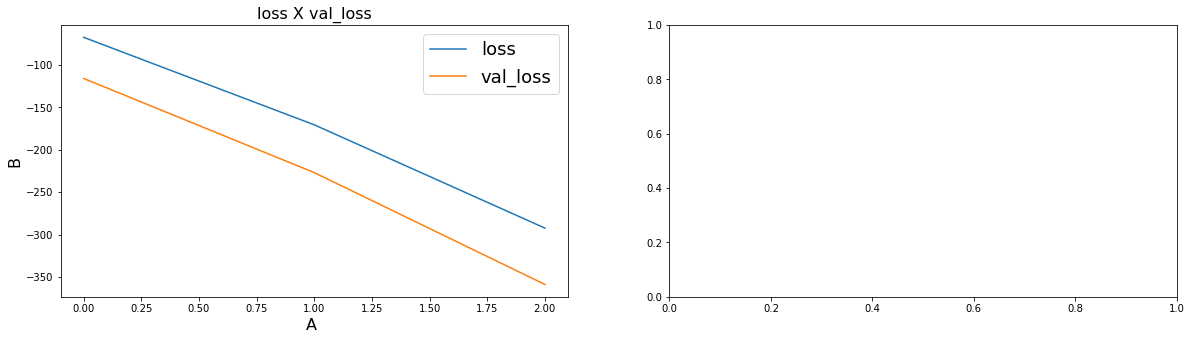

In [67]:
plot_learning_curves(history, [['loss', 'val_loss']])